In [47]:
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
import pystac_client
import stackstac
import hvplot.xarray

In [2]:
api_url = "https://earth-search.aws.element84.com/v1"
catalog = pystac_client.Client.open(
    api_url
)

In [8]:
# Get all the collection present in AWS
collections = list(catalog.get_all_collections())
collections

[<CollectionClient id=sentinel-2-pre-c1-l2a>,
 <CollectionClient id=cop-dem-glo-30>,
 <CollectionClient id=naip>,
 <CollectionClient id=cop-dem-glo-90>,
 <CollectionClient id=landsat-c2-l2>,
 <CollectionClient id=sentinel-2-l2a>,
 <CollectionClient id=sentinel-2-l1c>,
 <CollectionClient id=sentinel-2-c1-l2a>,
 <CollectionClient id=sentinel-1-grd>]

In [9]:
bn = gpd.read_file('bengaluru_north.geojson')

c:\Users\Ahmeds\.conda\envs\geo\Lib\site-packages\pyogrio\geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)
c:\Users\Ahmeds\.conda\envs\geo\Lib\site-packages\pyogrio\geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)


In [13]:
search = catalog.search(collections = 'sentinel-2-l2a',
                        bbox=bn.to_crs(4326).total_bounds,
                        datetime='2020-03-01/2020-05-01',
                        query=['eo:cloud_cover<10'])

In [14]:
# get all items
items_dict = [i.to_dict() for i in search.items()]
print(f"{len(items_dict)} scenes fetched")

15 scenes fetched


In [41]:
#Let's look at the band informations
selected_item = items_dict[1]
# Here are the assets available for this item
assets = selected_item['assets']

for key, asset in assets.items():
    if key=='granule_metadata' or key=='tileinfo_metadata':
        continue
    print(f"{key}: {asset['title']}")
    

aot: Aerosol optical thickness (AOT)
blue: Blue (band 2) - 10m
coastal: Coastal aerosol (band 1) - 60m
green: Green (band 3) - 10m
nir: NIR 1 (band 8) - 10m
nir08: NIR 2 (band 8A) - 20m
nir09: NIR 3 (band 9) - 60m
red: Red (band 4) - 10m
rededge1: Red edge 1 (band 5) - 20m
rededge2: Red edge 2 (band 6) - 20m
rededge3: Red edge 3 (band 7) - 20m
scl: Scene classification map (SCL)
swir16: SWIR 1 (band 11) - 20m
swir22: SWIR 2 (band 12) - 20m
thumbnail: Thumbnail image
visual: True color image
wvp: Water vapour (WVP)
aot-jp2: Aerosol optical thickness (AOT)
blue-jp2: Blue (band 2) - 10m
coastal-jp2: Coastal aerosol (band 1) - 60m
green-jp2: Green (band 3) - 10m
nir-jp2: NIR 1 (band 8) - 10m
nir08-jp2: NIR 2 (band 8A) - 20m
nir09-jp2: NIR 3 (band 9) - 60m
red-jp2: Red (band 4) - 10m
rededge1-jp2: Red edge 1 (band 5) - 20m
rededge2-jp2: Red edge 2 (band 6) - 20m
rededge3-jp2: Red edge 3 (band 7) - 20m
scl-jp2: Scene classification map (SCL)
swir16-jp2: SWIR 1 (band 11) - 20m
swir22-jp2: SWI

In [54]:
stack = stackstac.stack(items = items_dict, assets=["nir", "red", "green"],chunksize=2048)
# Clipping the raster w.t.r to BN vector
clip = stack.rio.clip(bn.geometry.values)

In [56]:
# Merging the same date data by grouping them by time and aggregation
clip = clip.groupby('time').mean()

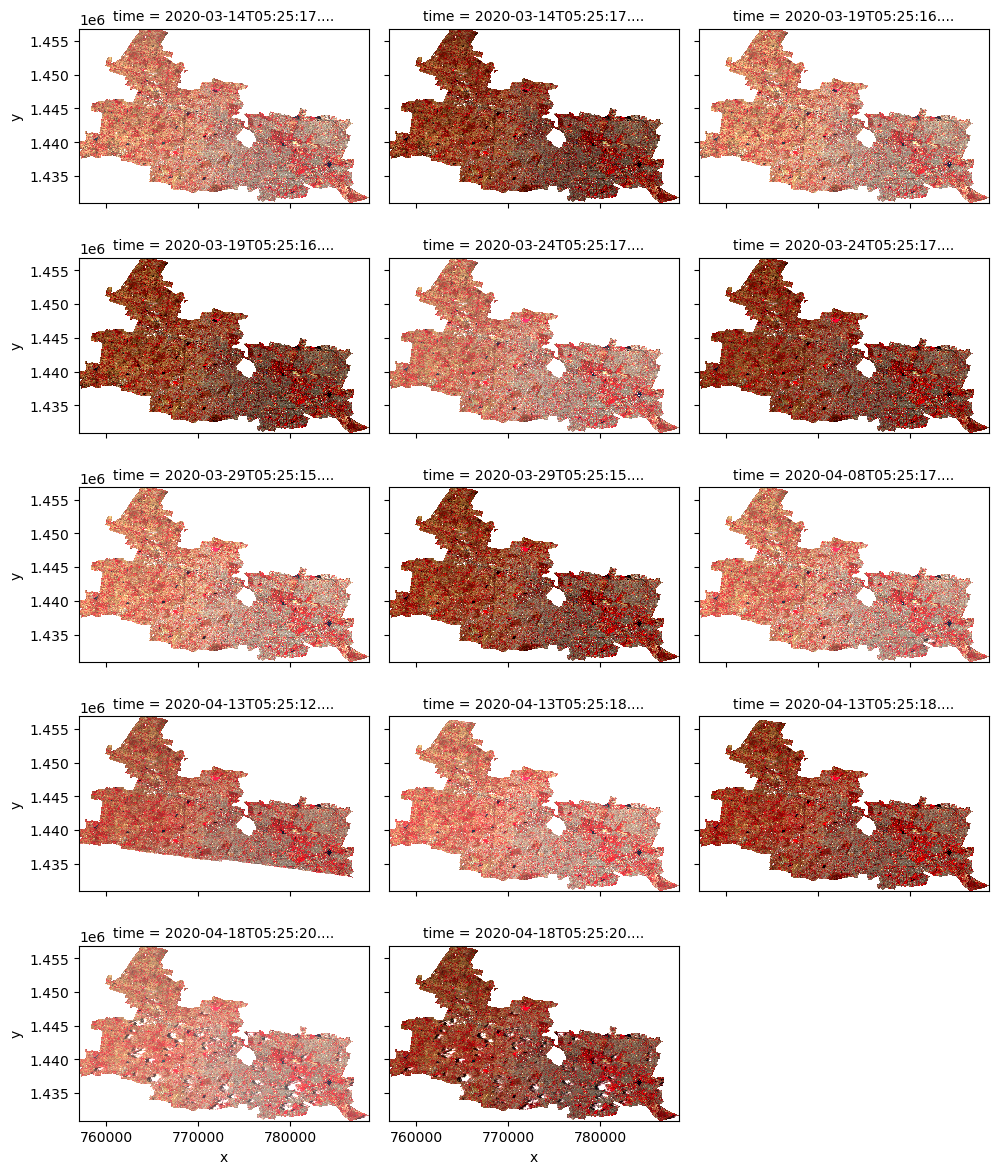

In [58]:
clip.plot.imshow(col='time',col_wrap=3,figsize=(10,12),robust=True)

In [62]:
# storing the median composite as geotif
clip.median(dim='time').rio.to_raster('data/raster/bn_median_composite.tif')